In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%pylab inline
import pandas as pd
import json
import seaborn
import copy
import os
from Chapter2.CreateDataset import CreateDataset
from util.VisualizeDataset import VisualizeDataset
from Chapter3.OutlierDetection import DistributionBasedOutlierDetection
from Chapter3.OutlierDetection import DistanceBasedOutlierDetection
from Chapter3.DataTransformation import LowPassFilter
from Chapter3.DataTransformation import PrincipalComponentAnalysis
from Chapter3.ImputationMissingValues import ImputationMissingValues
from Chapter3.KalmanFilters import KalmanFilters
from Chapter4.TemporalAbstraction import NumericalAbstraction
from Chapter4.TemporalAbstraction import CategoricalAbstraction
from Chapter4.FrequencyAbstraction import FourierTransformation
from Chapter4.TextAbstraction import TextAbstraction
from util.VisualizeDataset import VisualizeDataset
from util import util
from util.parser import get_labels,generate_csv,generate_labels,get_sensor_values
import time
print(os.getcwd())

Populating the interactive namespace from numpy and matplotlib
/home/cts/Desktop/ML4QS/Assignments/assignments_code_git/assignment3


# 0. Below cell has global variables (path-names mostly)

In [2]:
dataset_folder = './datasets'
figures_folder = './figures'

files = os.listdir(dataset_folder)
print(files)
dataset_fname  = 'log_assignment3'
event_fname = 'log_events_assignment3'
result_dataset_path = './intermediate_datafiles/'
csv_dataset_path = os.path.join(dataset_folder,'csv/')
dataset_path = os.path.join(dataset_folder,dataset_fname)
event_path = os.path.join(dataset_folder,event_fname)
output_fname = 'dataset.csv'

['log_assignment2', 'log_events_assignment3', 'log_assignment3', 'csv', 'log_events_assignment2']


In [3]:
if not os.path.exists(result_dataset_path):
    print('Creating result directory: ' + result_dataset_path)
    os.makedirs(result_dataset_path)
if not os.path.exists(csv_dataset_path):
    print('Creating result directory: ' + csv_dataset_path)
    os.makedirs(csv_dataset_path)
if not os.path.exists(figures_folder):
    print('Creating result directory: ' + figures_folder)
    os.makedirs(figures_folder)

# SECTION 1 : DATA PREPARATION

### 1. LOG PARSING FUNCTION CALL

In [4]:
labels = get_labels(dataset_path)
print('Label Mappings:\n')
print(json.dumps(labels,indent=2))


Label Mappings:

{
  "stairsdown": [
    1, 
    3, 
    5, 
    7, 
    9, 
    11
  ], 
  "stairsup": [
    2, 
    4, 
    6, 
    8, 
    10, 
    12
  ], 
  "walking": [
    13
  ]
}


In [5]:
sensors_dict = get_sensor_values(dataset_path)
print('Sensors in log file')
sensors = sensors_dict.keys()
print(json.dumps(sensors,indent=2))

Sensors in log file
[
  "bmi160 accelerometer", 
  "bmi160 gyroscope", 
  "rotation vector"
]


## 1.2 CSV generation cell

In [6]:
for sensor in sensors:
    if sensor == 'rotation vector':
        generate_csv(sensors_dict[sensor],
                     header=['x','y','z','theta','phi','timestamp'],
                     fname = os.path.join(csv_dataset_path,sensor+'.csv'))
    else:
        generate_csv(sensors_dict[sensor],fname = os.path.join(csv_dataset_path,sensor+'.csv'))
generate_labels(fname=event_path,log_fname=dataset_path,fout=csv_dataset_path+'labels.csv');

### 1.3 Dataset creation cell (Most important here we tweak granularities)>

In [7]:
granularities = [50,100,150,200,250,500,1000,5000]
datasets = []
dataset_names = []

for milliseconds_per_instance in granularities:
    initial = time.time()
    # Create an initial dataset object with the base directory for our data and a granularity
    DataSet = CreateDataset(csv_dataset_path, milliseconds_per_instance)
    print('granularity is %d ms'%milliseconds_per_instance)
    
    DataSet.add_numerical_dataset('bmi160 accelerometer.csv','timestamp',['x','y','z'],'avg','acc_phone_')
    DataSet.add_numerical_dataset('bmi160 gyroscope.csv','timestamp',['x','y','z'],'avg','gyr_phone_')
    DataSet.add_numerical_dataset('rotation vector.csv','timestamp',['x','y','z','theta','phi'],'avg','rotation_phone_')
    DataSet.add_event_dataset('labels.csv','label_start','label_end','label','binary')
    print('Added all sensors and labels')
    dataset = DataSet.data_table
#     util.print_statistics(dataset)
    datasets.append(copy.deepcopy(dataset))
    fname = str(milliseconds_per_instance)+ '_dataset.csv'
    path = os.path.join(result_dataset_path,fname)
    dataset_names.append(fname)
    dataset.to_csv(path)
    print('Dataset created,\tDuration:%.5f seconds'%(time.time()-initial))
    print('====================================')
    


granularity is 50 ms
Added all sensors and labels
Dataset created,	Duration:60.78567 seconds
granularity is 100 ms
Added all sensors and labels
Dataset created,	Duration:29.60810 seconds
granularity is 150 ms
Added all sensors and labels
Dataset created,	Duration:20.13934 seconds
granularity is 200 ms
Added all sensors and labels
Dataset created,	Duration:15.50905 seconds
granularity is 250 ms
Added all sensors and labels
Dataset created,	Duration:13.39043 seconds
granularity is 500 ms
Added all sensors and labels
Dataset created,	Duration:6.93800 seconds
granularity is 1000 ms
Added all sensors and labels
Dataset created,	Duration:3.50315 seconds
granularity is 5000 ms
Added all sensors and labels
Dataset created,	Duration:1.49970 seconds


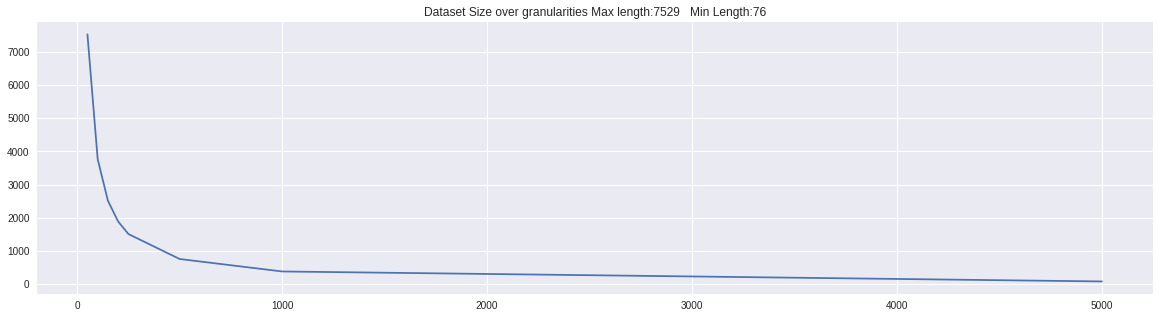

In [52]:
rcParams['figure.figsize'] = (20,5)
lengths = [len(x) for x in datasets]
plt.plot(granularities,lengths)
plt.title('Dataset Size over granularities Max length:%d   Min Length:%d'%(lengths[0],lengths[-1]))
plt.show()

### 1.4 Some visualizations (this needs above cell to run)

Dataset 1:	Using 50 milliseconds, size:7529 steps: 37


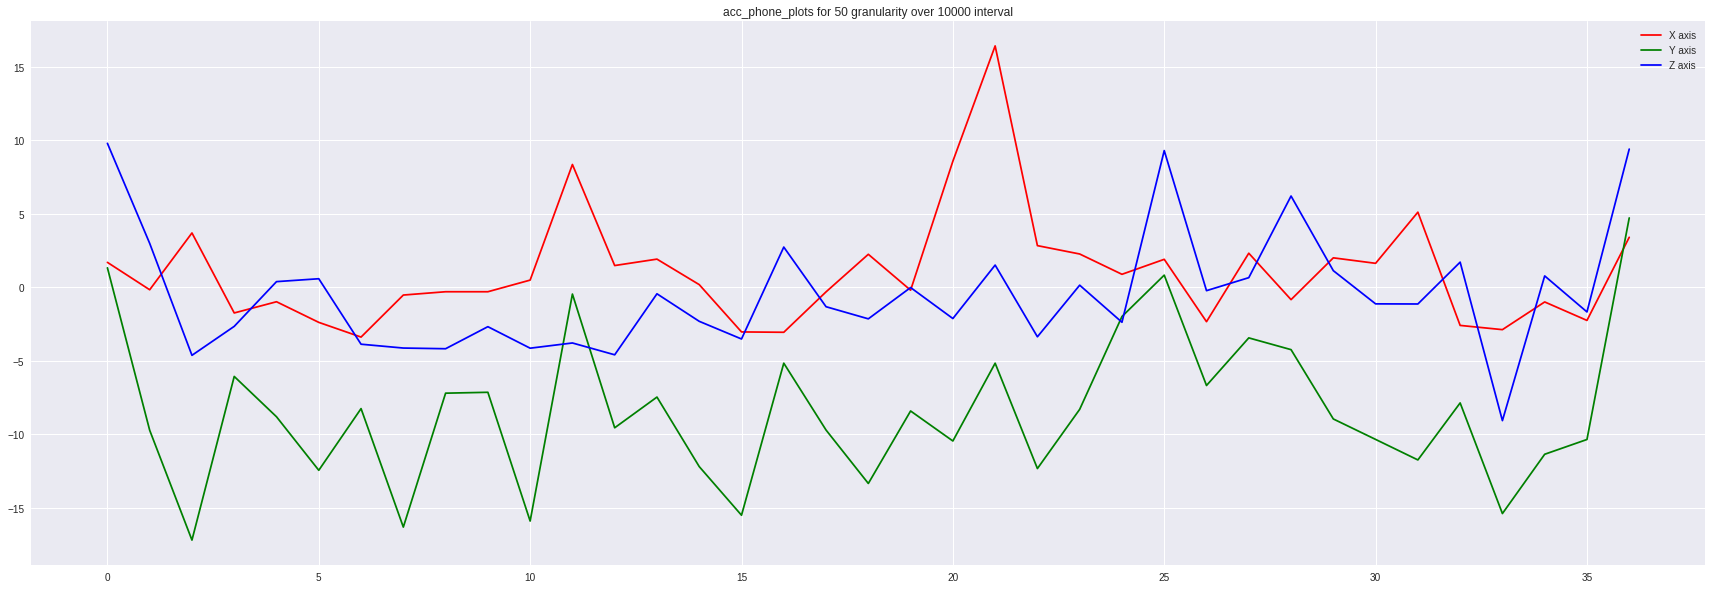

Dataset 2:	Using 100 milliseconds, size:3765 steps: 37


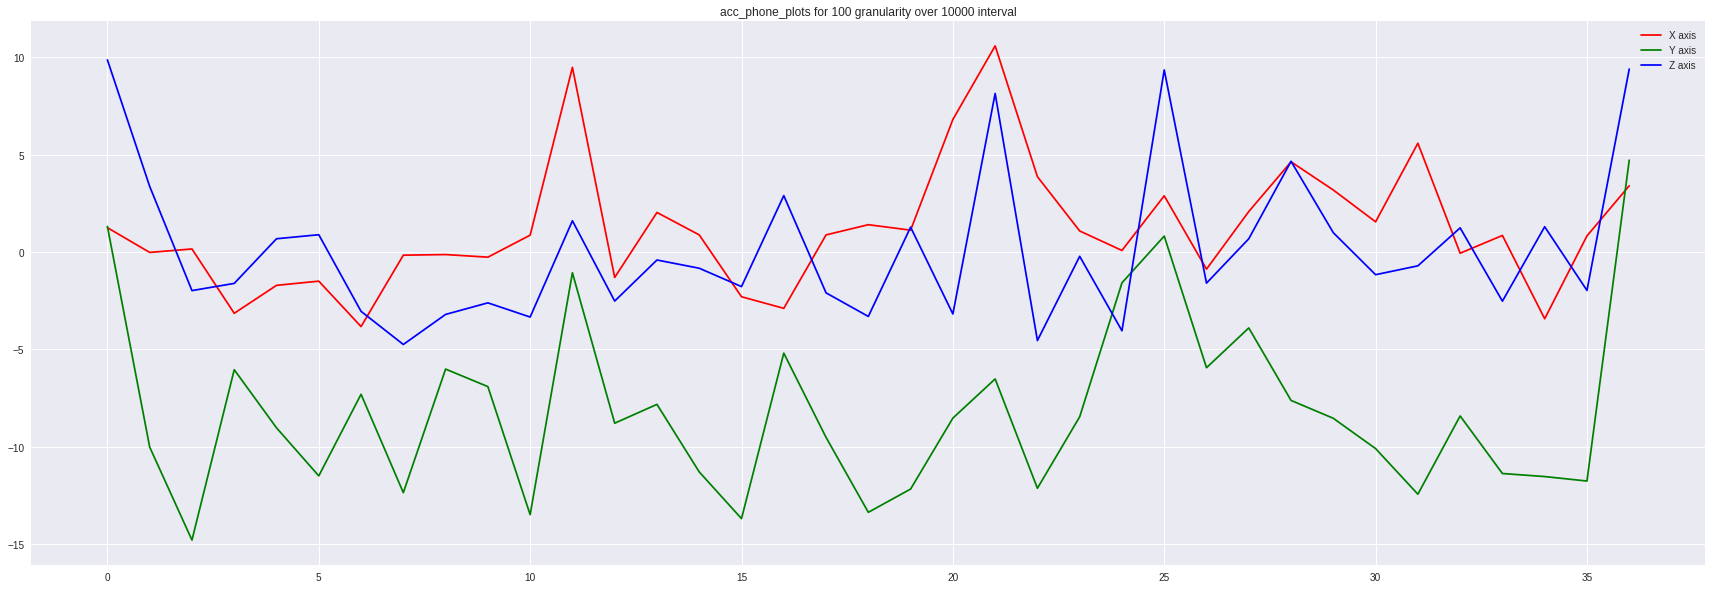

Dataset 3:	Using 150 milliseconds, size:2510 steps: 38


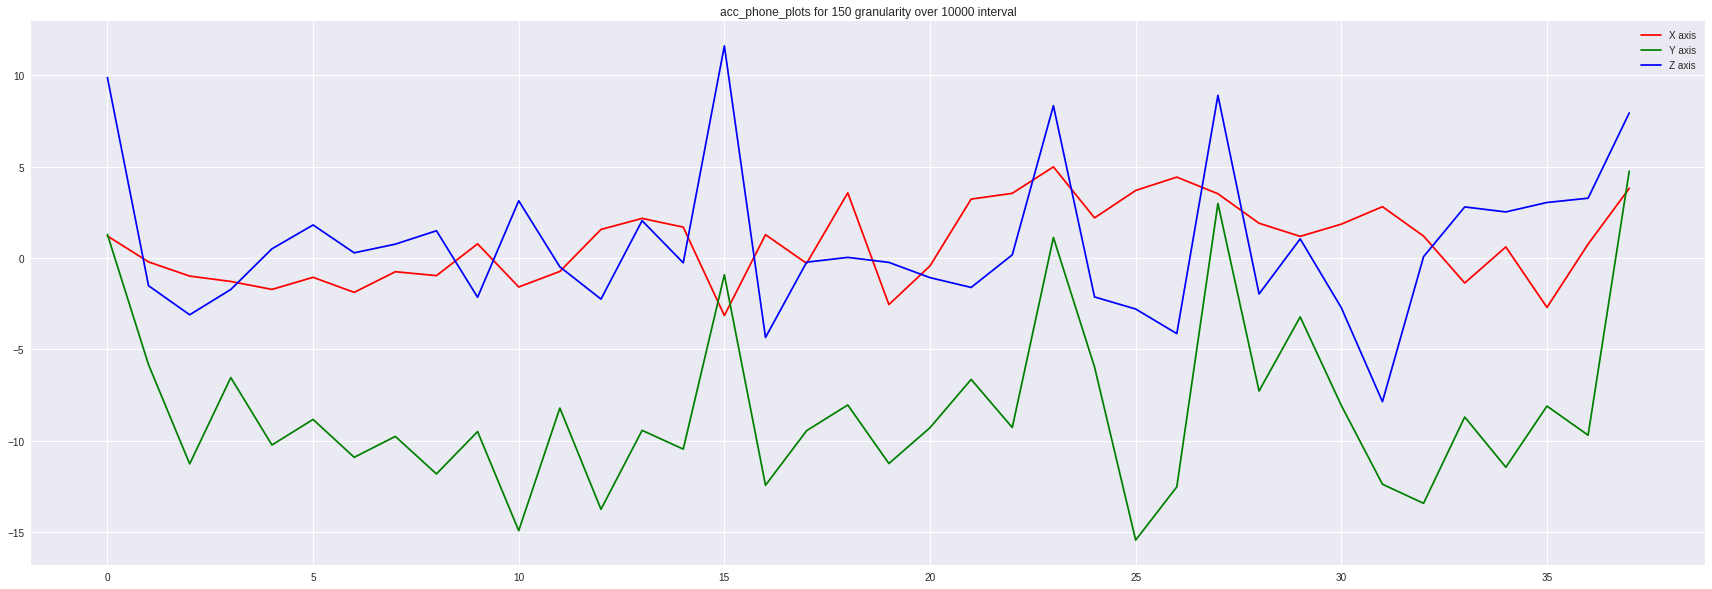

Dataset 4:	Using 200 milliseconds, size:1883 steps: 37


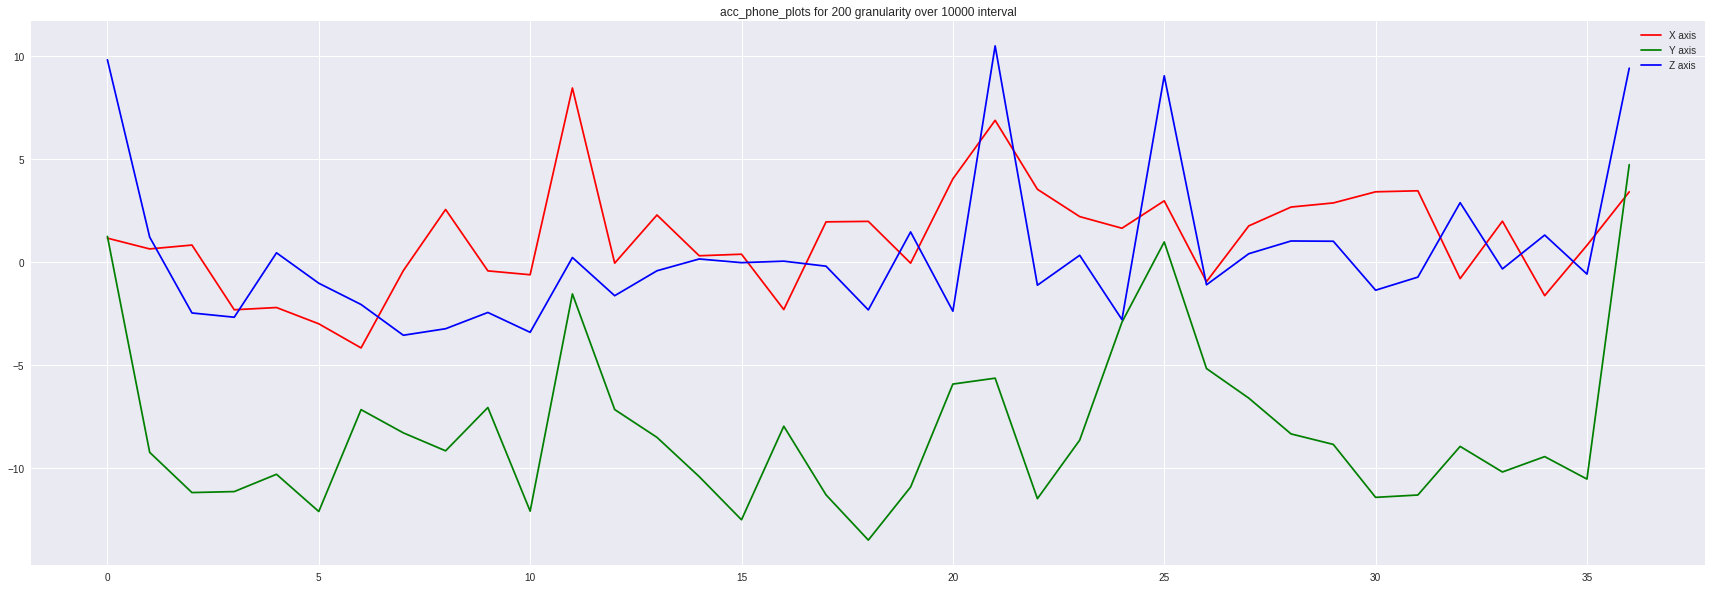

Dataset 5:	Using 250 milliseconds, size:1506 steps: 37


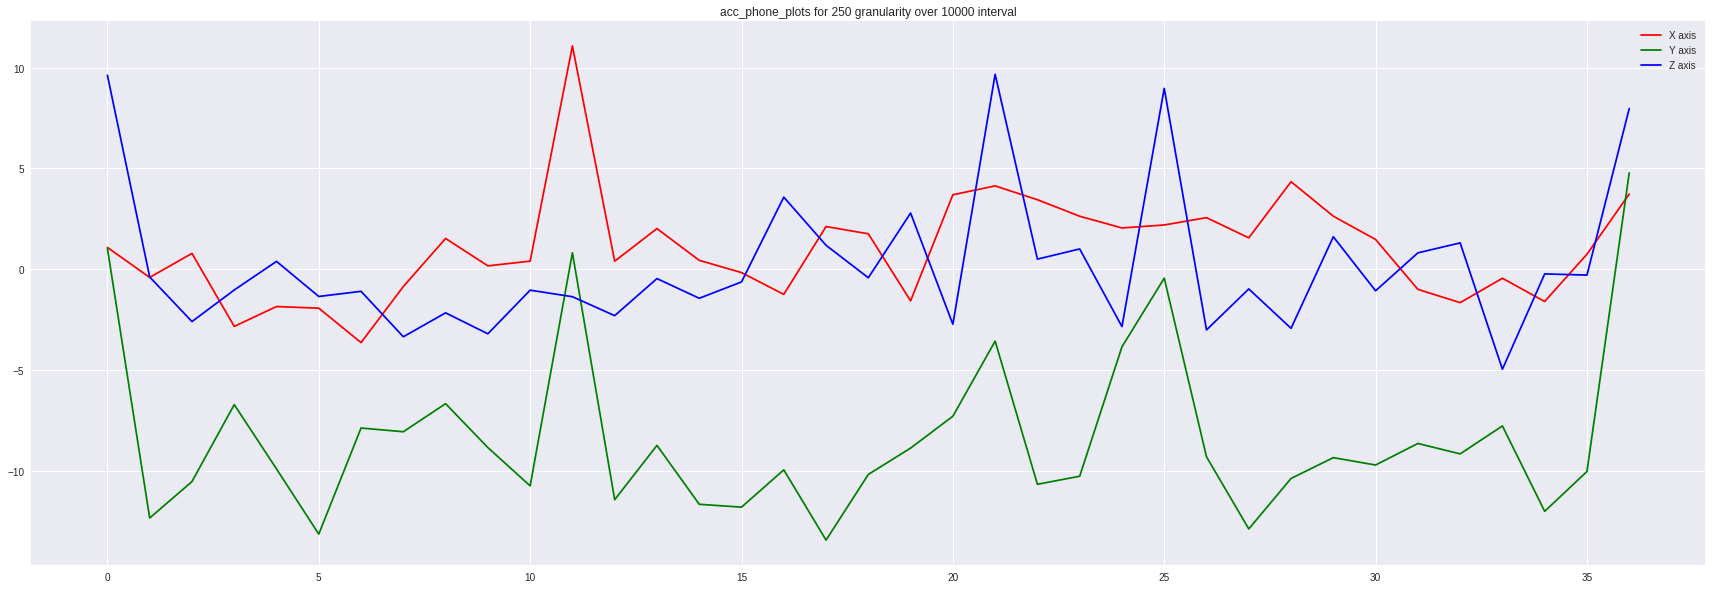

Dataset 6:	Using 500 milliseconds, size:753 steps: 37


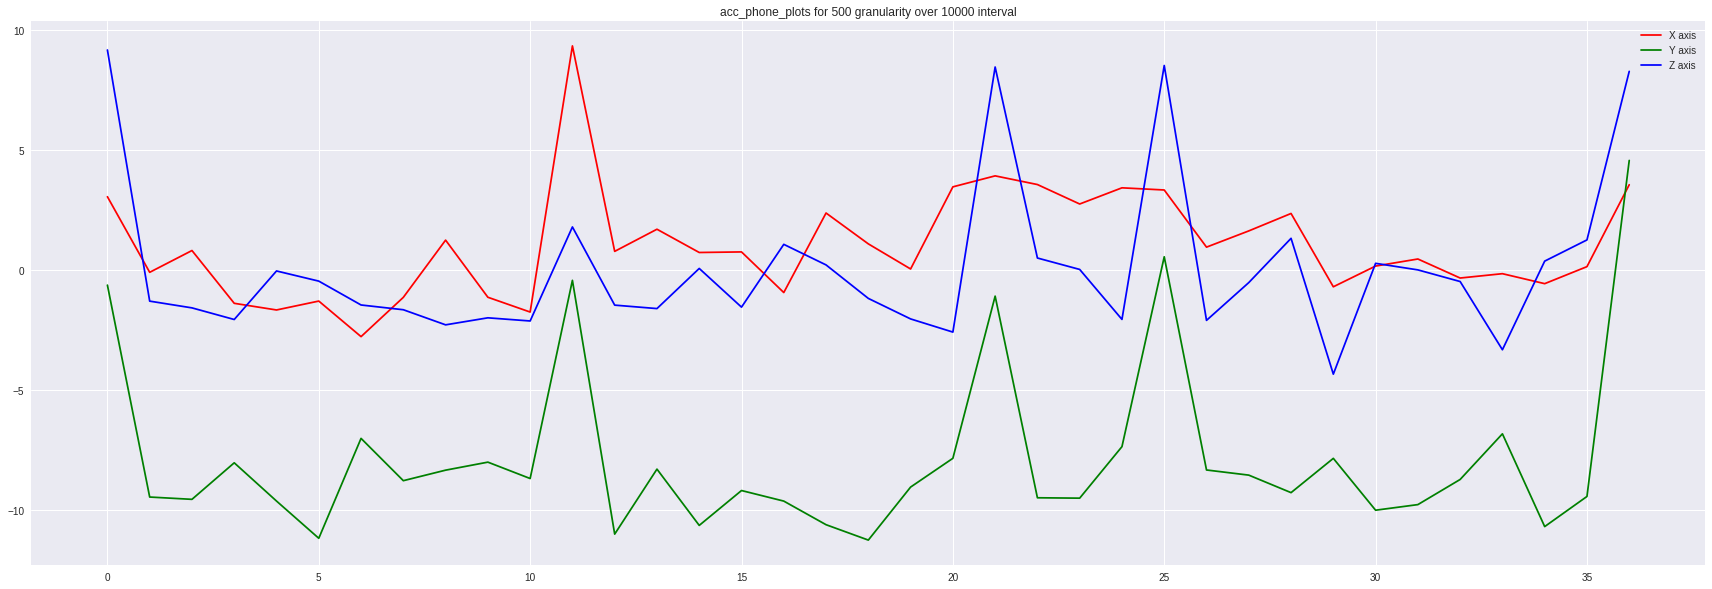

Dataset 7:	Using 1000 milliseconds, size:377 steps: 37


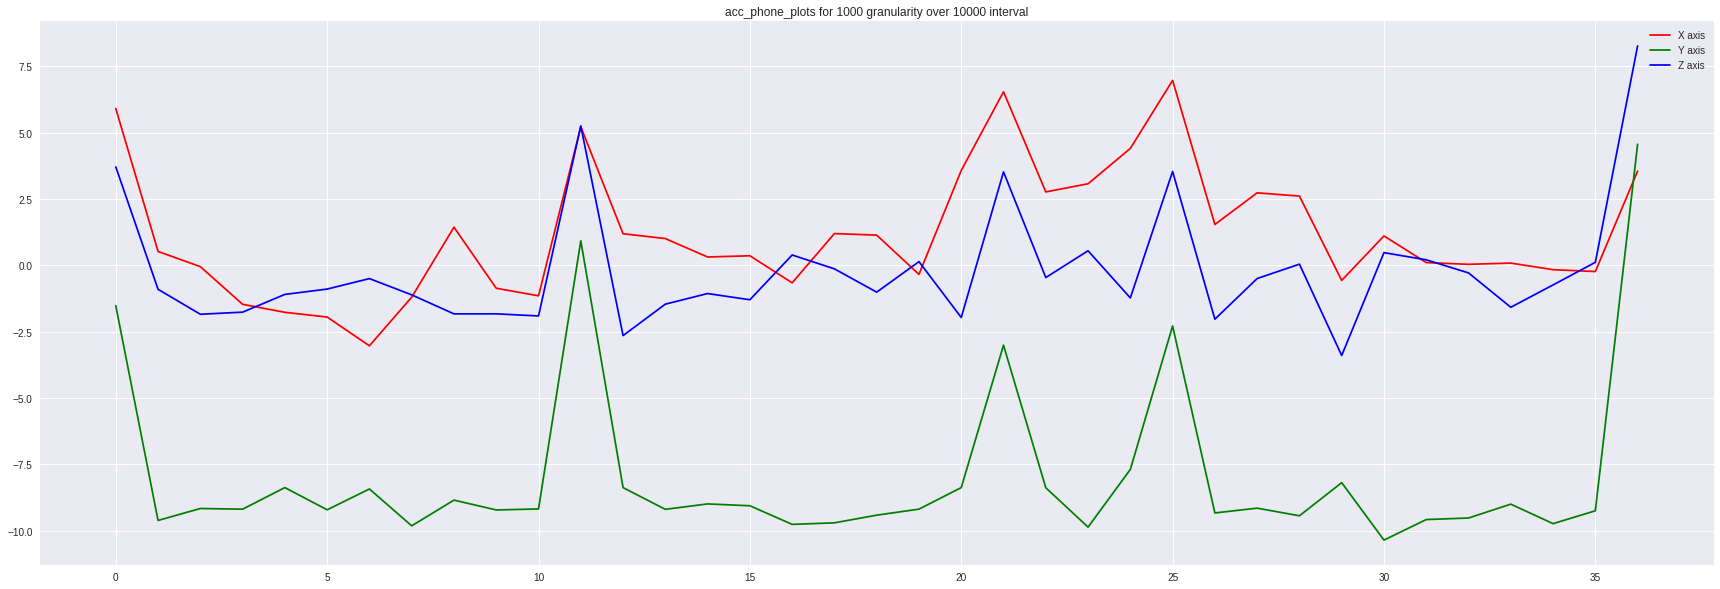

Dataset 8:	Using 5000 milliseconds, size:76 steps: 38


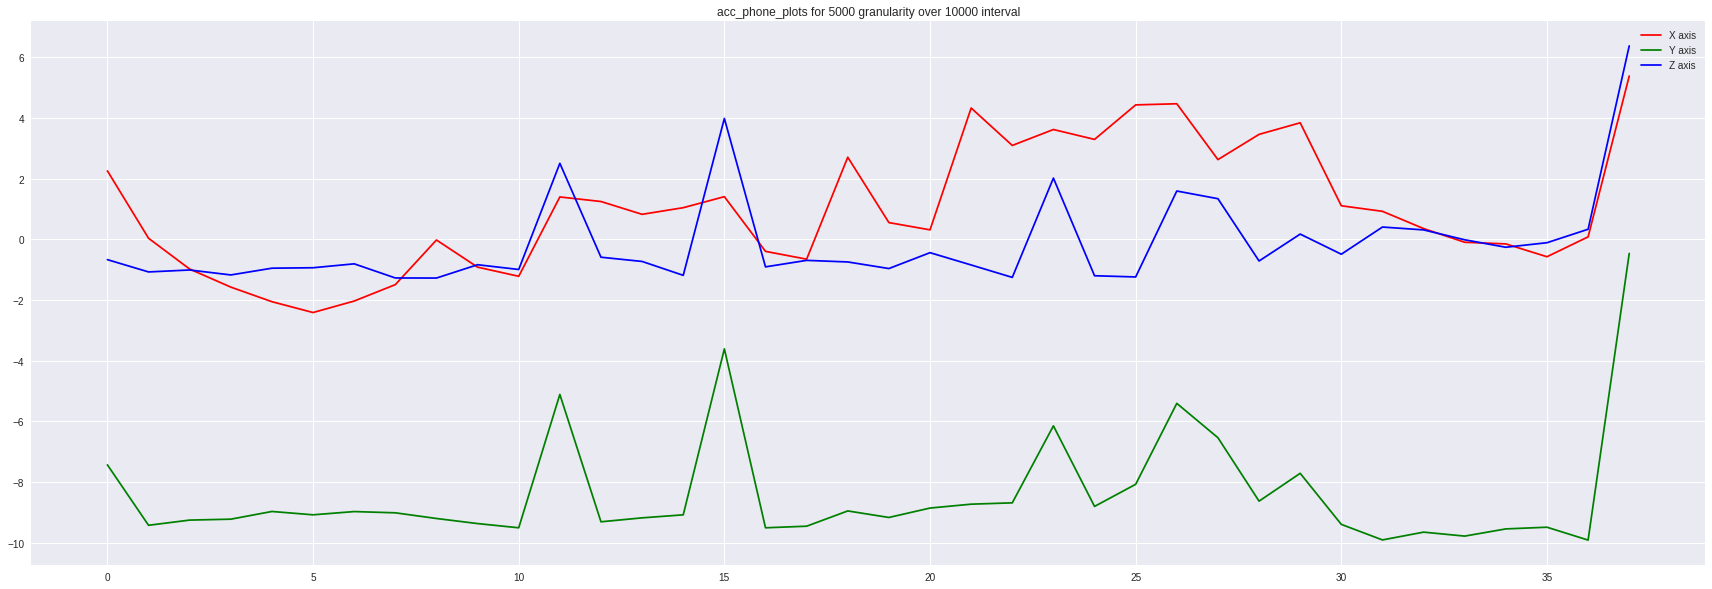

In [53]:
DataViz = VisualizeDataset()
rcParams['figure.figsize'] = (30,10)
interval = 10000 # 10 second interval plot

prefix = 'acc_phone_'
for d_index in range(len(datasets)):
    millis = granularities[d_index]
    indices = floor(np.linspace(0,len(datasets[d_index])-1,len(datasets[d_index])//(interval//millis)))
    indices = indices.astype(int)
    xx = np.arange(len(indices))
    print('Dataset %d:\tUsing %d milliseconds, size:%d steps: %d'%(d_index+1,millis,len(datasets[d_index]),len(indices),))
    
    y1 = datasets[d_index][prefix+'x'][indices]
    y2 = datasets[d_index][prefix+'y'][indices]
    y3 = datasets[d_index][prefix+'z'][indices]
    plt.plot(xx,y1,'r')
    plt.plot(xx,y2,'g')
    plt.plot(xx,y3,'b')
    plt.legend(['X axis','Y axis','Z axis'])
    plt.title(prefix+'plots for %d granularity over %d interval'%(millis,interval))
    plt.savefig(os.path.join(figures_folder,prefix+str(millis)+'_'+'axes.png'))    
    plt.show()


## 1.5 More visualizations on tommie's request....

millis:50 , start:2017-06-25 00:23:33.041000	end:2017-06-25 00:23:37.991000


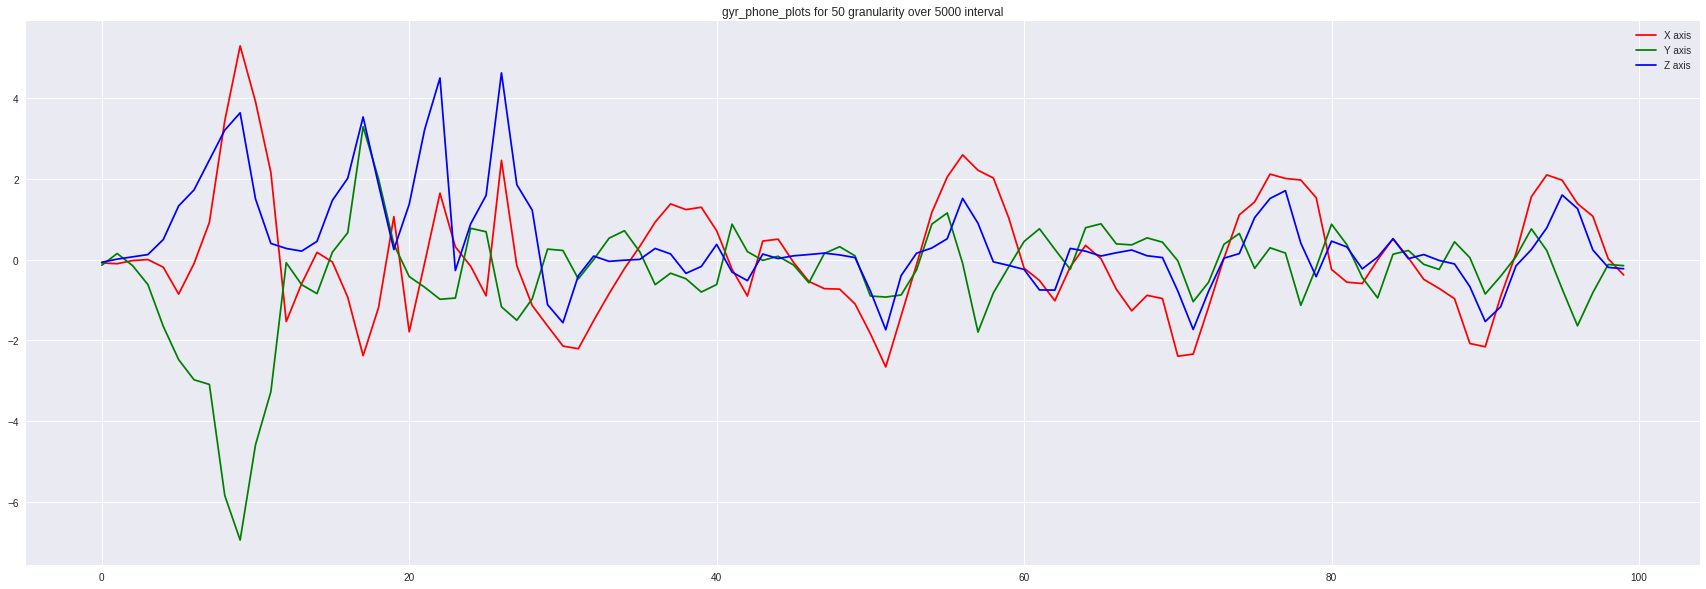

millis:100 , start:2017-06-25 00:23:33.041000	end:2017-06-25 00:23:37.941000


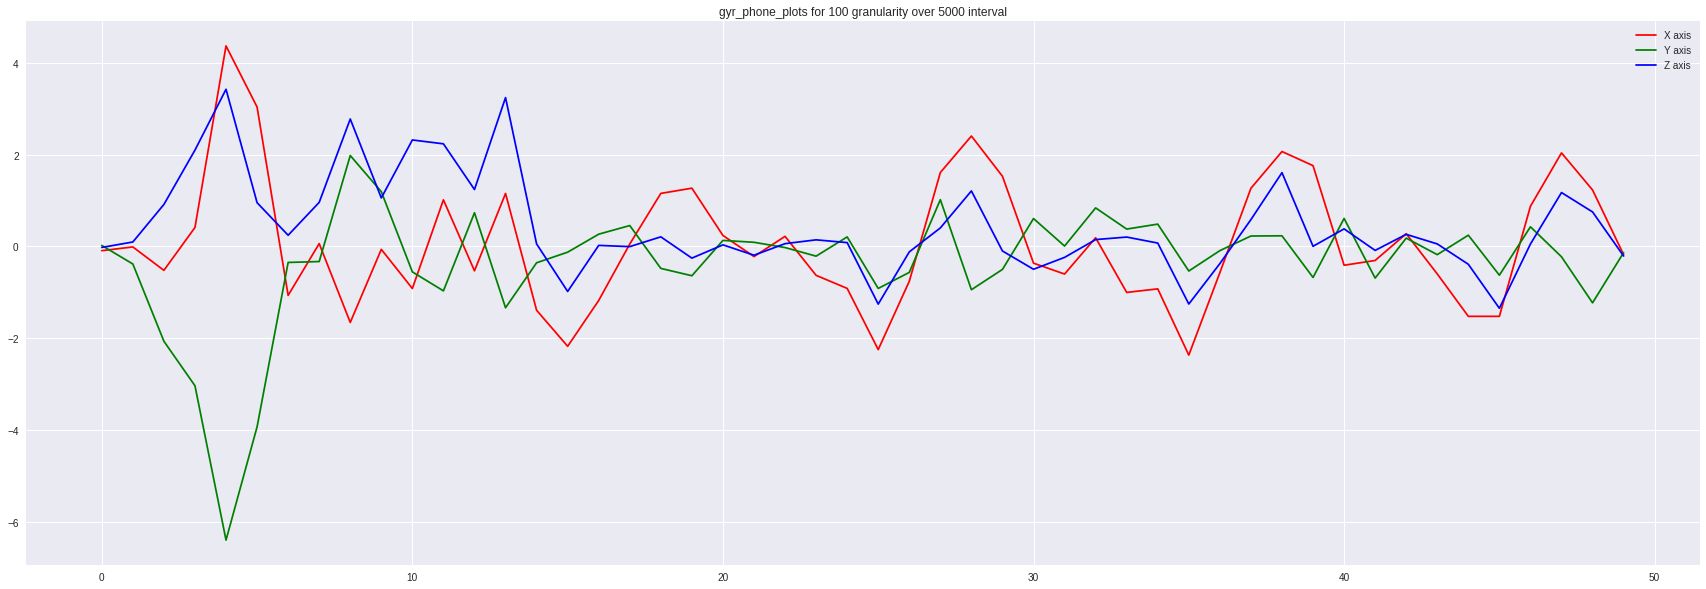

millis:150 , start:2017-06-25 00:23:33.041000	end:2017-06-25 00:23:37.841000


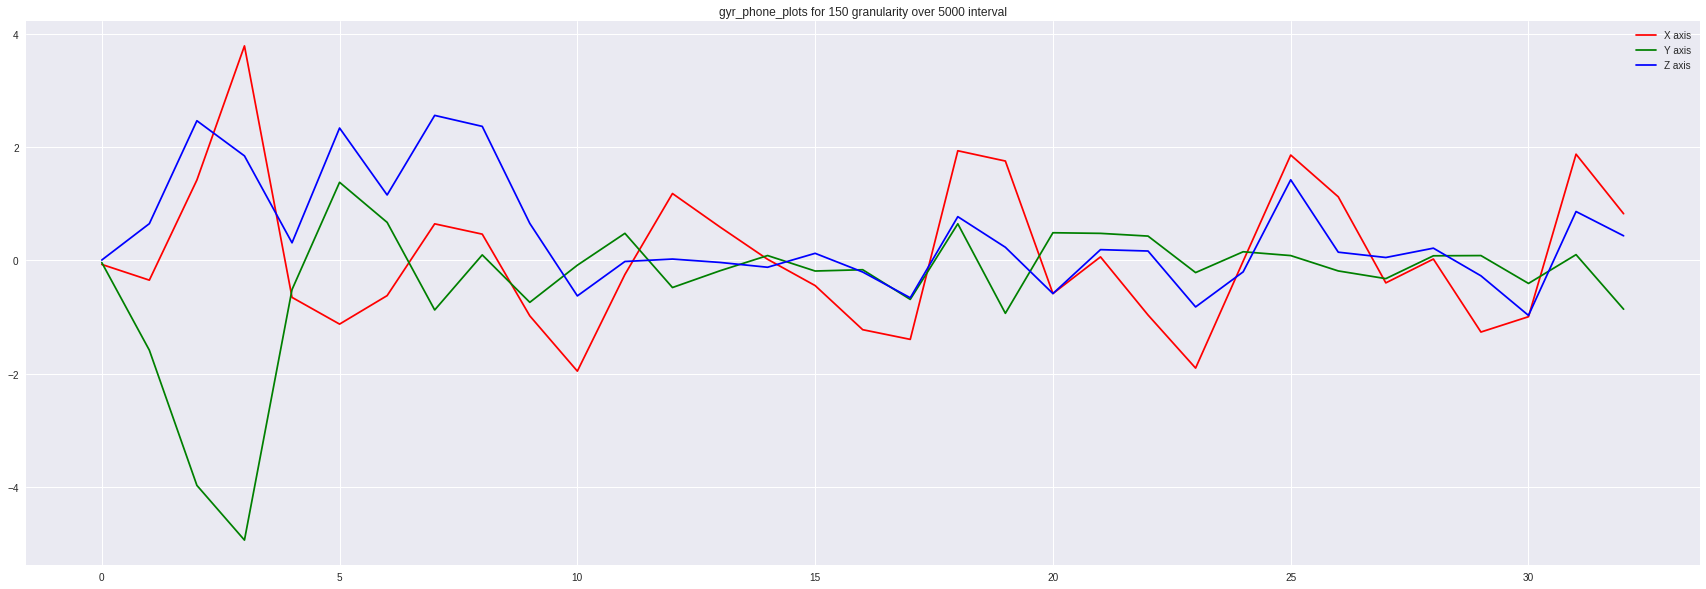

millis:200 , start:2017-06-25 00:23:33.041000	end:2017-06-25 00:23:37.841000


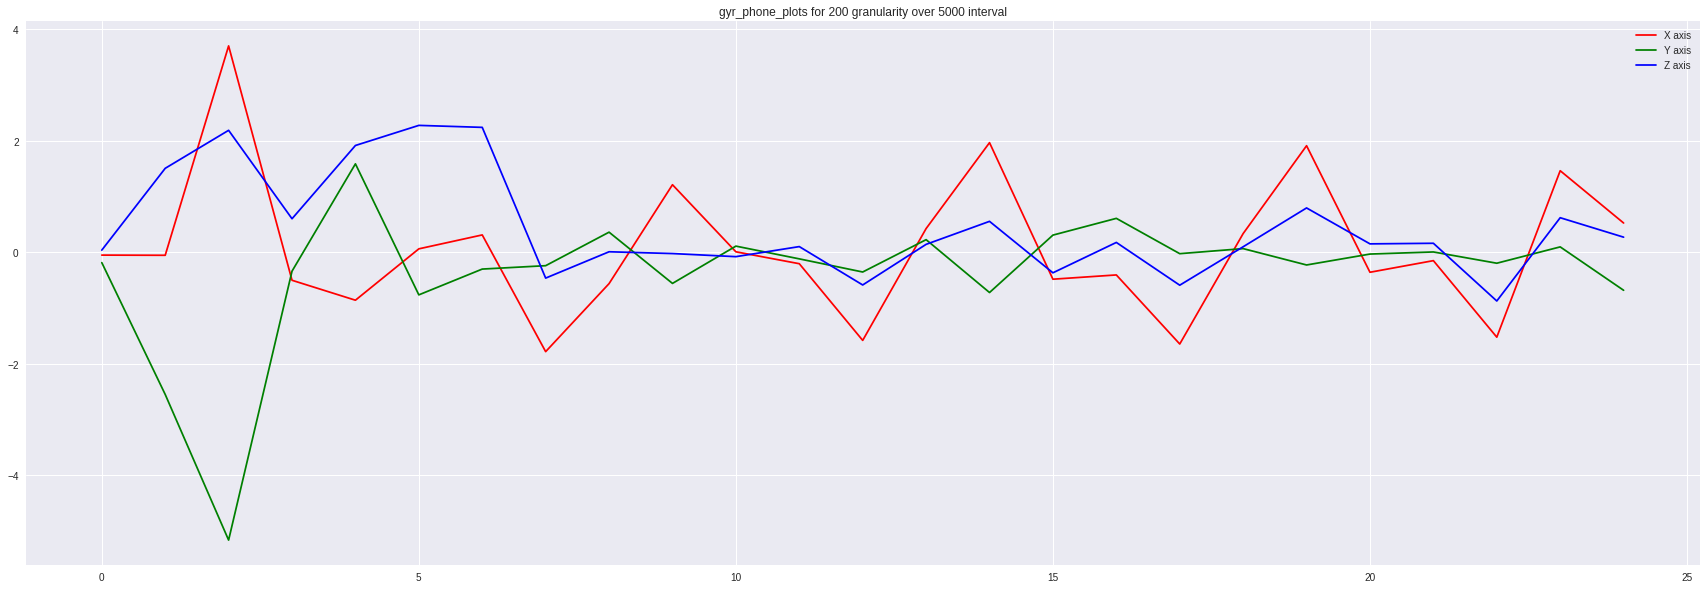

millis:250 , start:2017-06-25 00:23:33.041000	end:2017-06-25 00:23:37.791000


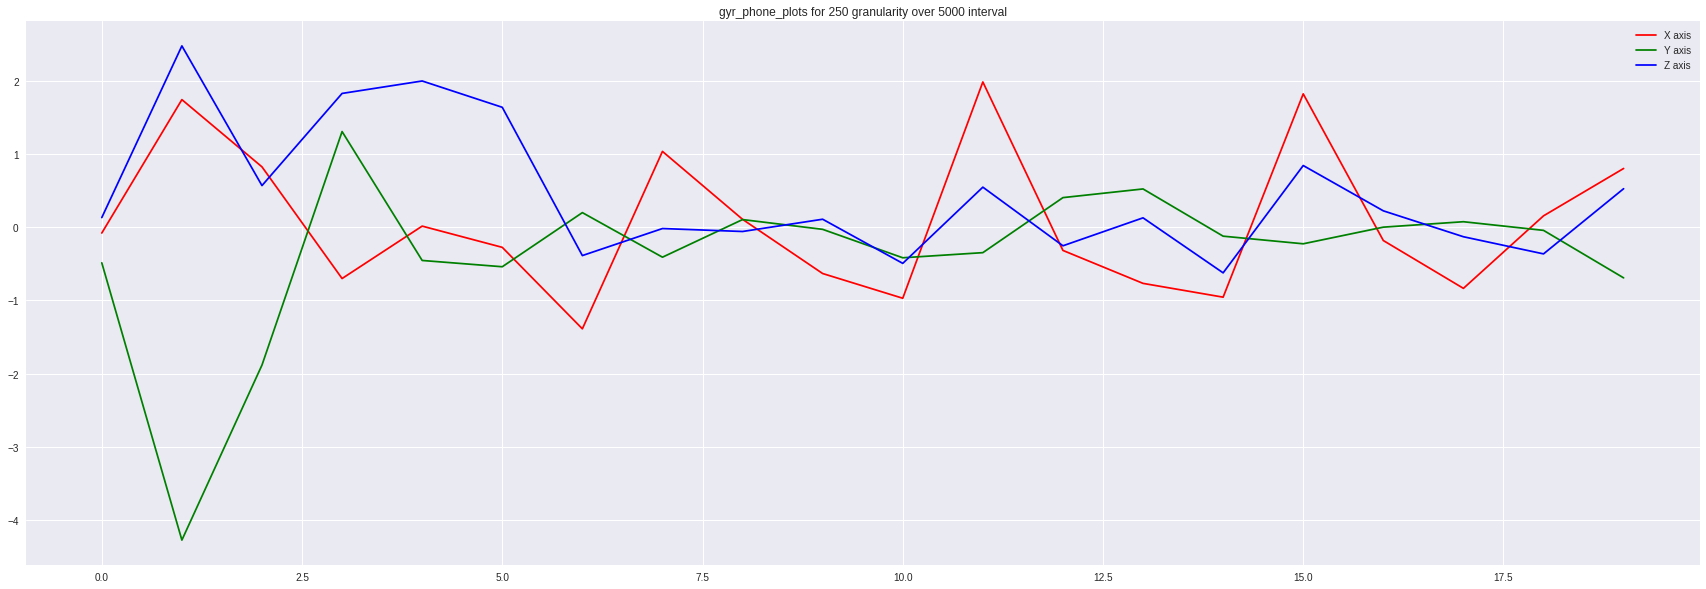

millis:500 , start:2017-06-25 00:23:33.041000	end:2017-06-25 00:23:37.541000


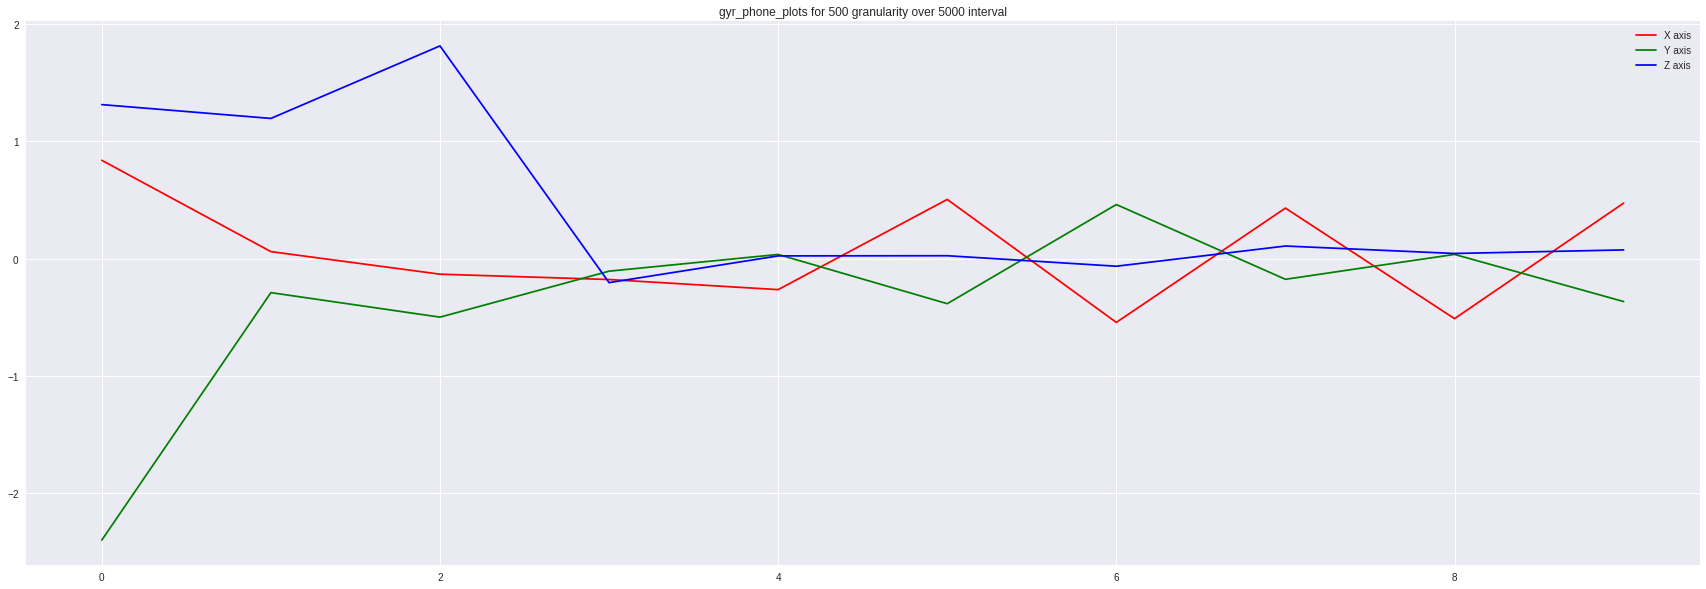

millis:1000 , start:2017-06-25 00:23:33.041000	end:2017-06-25 00:23:37.041000


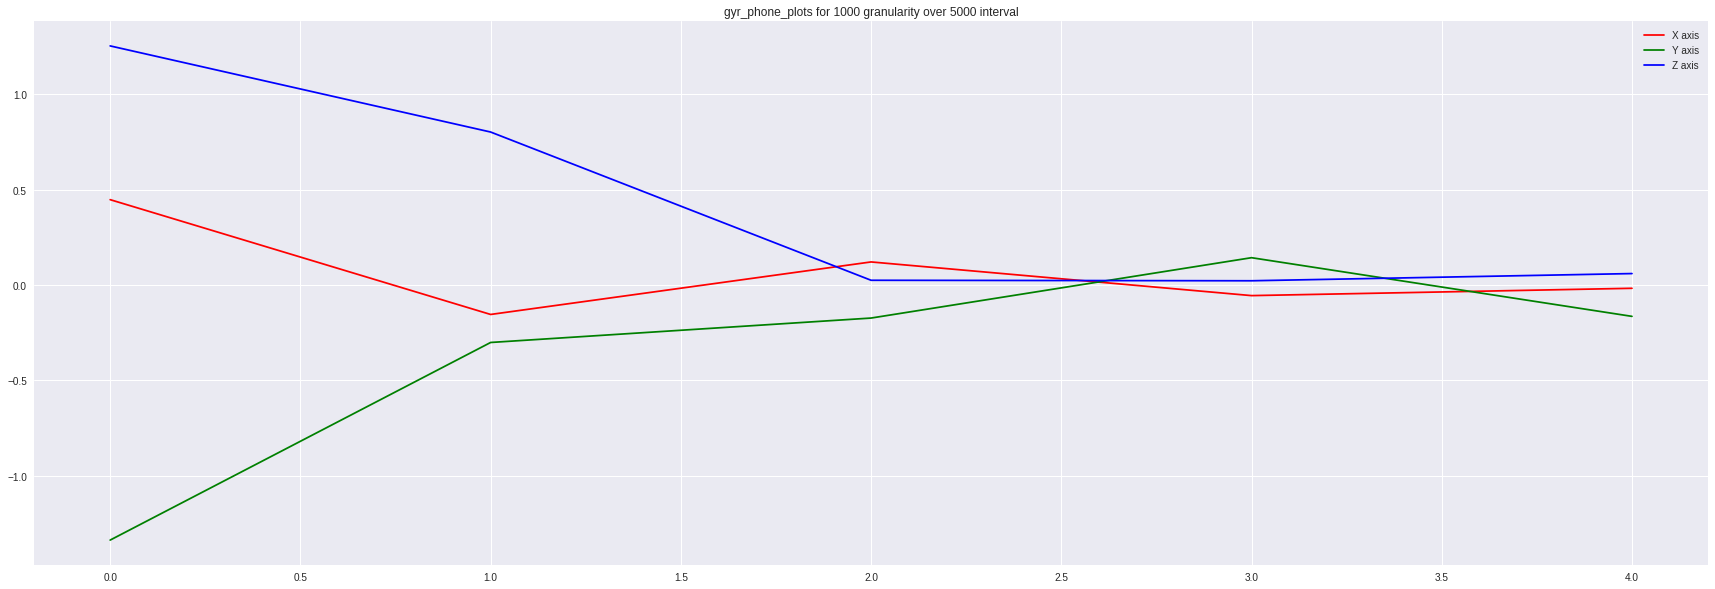

millis:5000 , start:2017-06-25 00:23:33.041000	end:2017-06-25 00:23:33.041000


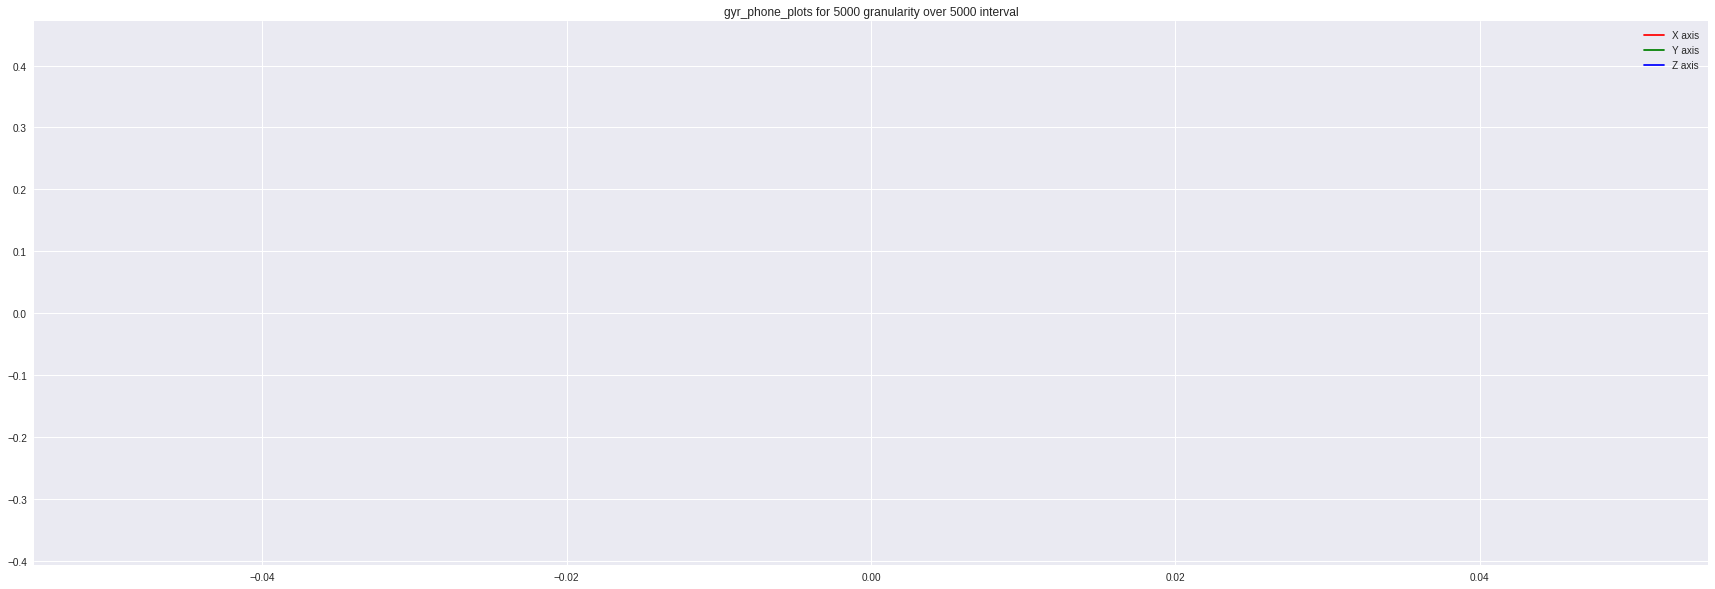

In [42]:
max_range = 5000
prefix = 'gyr_phone_'
start_index = 0
rcParams['figure.figsize'] = (30,10)

for i in range(len(datasets)):
    millis = granularities[i]
    end_index = int(max_range/millis)
    start = datasets[i].index[start_index]
    
    end = datasets[i].index[end_index] -1
    indices = range(start_index,end_index)
    xx = np.arange(end_index)
    print('millis:%d , start:%s\tend:%s'%(millis,str(start),str(end)))
    y1 = datasets[i][prefix+'x'][indices]
    y2 = datasets[i][prefix+'y'][indices]
    y3 = datasets[i][prefix+'z'][indices]
    
    plt.plot(xx,y1,'r')
    plt.plot(xx,y2,'g')
    plt.plot(xx,y3,'b')
    if 'rotation' in prefix:
        y4 = datasets[i][prefix+'theta'][indices]
        y5 = datasets[i][prefix+'phi'][indices]
        plt.plot(xx,y4,'k')
        plt.plot(xx,y4,'y')        
        plt.legend(['X axis','Y axis','Z axis','Theta','Phi'])
    else:
        plt.legend(['X axis','Y axis','Z axis'])
    plt.title(prefix+'plots for %d granularity over %d interval'%(millis,max_range))
    plt.savefig(os.path.join(figures_folder,prefix+str(millis)+'over_'+str(max_range)+'_'+'features.png'))    
    plt.show()
#     plt.plot(datasets[i]['labelstairsup'][indices]+0.02,'ro')
#     plt.plot(datasets[i]['labelstairsdown'][indices]-0.02,'bo')
#     plt.plot(datasets[i]['labelwalking'][indices]+0.05,'go')
#     plt.legend(['stairs up','stairs down','walking'])
#     plt.savefig(os.path.join(figures_folder,prefix+str(millis)+'over_'+str(max_range)+'_'+'labels.png')) 
#     plt.show()

### 1.6 Old visualizations , plotting only by step.

# SECTION 2 Data Filtering Cell (U can continue from here)

In [9]:
### choose a dataset to filter:
DataViz = VisualizeDataset()
rcParams['figure.figsize'] = (20,10)
data_index = 1
try:
    dataset = pd.read_csv(os.path.join(result_dataset_path,dataset_names[data_index])
                          ,index_col=0) # minimum granularity - biggest dataset
    millis = granularities[data_index]
except NameError:
    print(os.listdir(result_dataset_path))
    dataset_names = os.listdir(result_dataset_path)
    dataset_names = [x for x in dataset_names if 'dataset' in x and not 'lock' 
                     in x and not 'kalman' in x and not 'outlier' in x and not 'rest' in x
                     and not 'ws' in x]
#     print(dataset_names)
    granularities = [int(x.split('_')[0]) for x in dataset_names if 'dataset' in x]
    dataset = pd.read_csv(os.path.join(result_dataset_path,dataset_names[data_index])
                          ,index_col=0) # minimum granularity - biggest dataset
    millis = granularities[data_index]
    
dataset.index = pd.to_datetime(dataset.index)
milliseconds_per_instance = (dataset.index[1] - dataset.index[0]).microseconds/1000
print("Using milliseconds per instance: %d"%milliseconds_per_instance)
outlier_columns = [ x for x in dataset.keys() if 'label' not in x]
print('Detecting outliers in columnns:%s'%json.dumps(outlier_columns,indent=2))

Using milliseconds per instance: 100
Detecting outliers in columnns:[
  "acc_phone_x", 
  "acc_phone_y", 
  "acc_phone_z", 
  "gyr_phone_x", 
  "gyr_phone_y", 
  "gyr_phone_z", 
  "rotation_phone_x", 
  "rotation_phone_y", 
  "rotation_phone_z", 
  "rotation_phone_theta", 
  "rotation_phone_phi"
]


### Section 2.1 : Outlier detection 

In [12]:
OutlierDistr = DistributionBasedOutlierDetection()
OutlierDist = DistanceBasedOutlierDetection()

#And investigate the approaches for all relevant attributes.
for col in outlier_columns:
    # And try out all different approaches. Note that we have done some optimization
    # of the parameter values for each of the approaches by visual inspection.
#     dataset = OutlierDistr.chauvenet(dataset, col)
#     DataViz.plot_binary_outliers(dataset, col, col + '_outlier')
#     dataset = OutlierDistr.mixture_model(dataset, col)
#     DataViz.plot_dataset(dataset, [col, col + '_mixture'], ['like','like'], ['line', 'points'])
    # This requires:
    # n_data_points * n_data_points * point_size =
    # 31839 * 31839 * 64 bits = ~8GB available memory
#     try:
#         dataset = OutlierDist.simple_distance_based(dataset, [col], 'euclidean', 0.10, 0.99)
# #         DataViz.plot_binary_outliers(dataset, col, 'simple_dist_outlier')
#     except MemoryError as e:
#         print('Not enough memory available for simple distance-based outlier detection...')
#         print('Skipping.')
    
#     try:
#         dataset = OutlierDist.local_outlier_factor(dataset, [col], 'euclidean', 5)
#     except MemoryError as e:
#         print('Not enough memory available for lof...')
#         print('Skipping.')

    # Remove all the stuff from the dataset again.
#     cols_to_remove = [col + '_outlier', col + '_mixture', 'simple_dist_outlier', 'lof']
#     for to_remove in cols_to_remove:
#         if to_remove in dataset:
#             del dataset[to_remove]
    pass
# We take Chauvent's criterion and apply it to all but the label data...

for col in [c for c in dataset.columns if not 'label' in c]:
#     print('Measurement is now: ' , col)
    dataset = OutlierDistr.chauvenet(dataset, col)
    dataset.loc[dataset[col + '_outlier'] == True, col] = np.nan
    del dataset[col + '_outlier']
dataset.to_csv(result_dataset_path +str(millis)+'_chauvenet_outlier.csv')


###  Section 2.2 Apply Kalman Filtering to the dataset  (Chauvenet)

In [15]:
rcParams['figure.figsize'] = (20,10)
DataViz = VisualizeDataset()
millis = 100
missing_values = [c for c in dataset.columns if not 'label' in c]
original_dataset = pd.read_csv(result_dataset_path+str(millis)+'_chauvenet_outlier.csv',index_col=0)
original_dataset.index = pd.to_datetime(original_dataset.index)
KalFilter = KalmanFilters()
value = missing_values[0]
print('Filtering out %s value'%value)
kalman_dataset = KalFilter.apply_kalman_filter(original_dataset,value)

for value in missing_values[1:]:
    print('Filtering out %s value'%value)
    kalman_dataset = KalFilter.apply_kalman_filter(kalman_dataset,value)
#     DataViz.plot_dataset(kalman_dataset, [value,value+'_kalman'], ['exact','exact'], ['line', 'line'])
kalman_dataset.to_csv(result_dataset_path+'/'+str(millis)+'_kalman_dataset.csv')

Filtering out acc_phone_x value
Filtering out acc_phone_y value
Filtering out acc_phone_z value
Filtering out gyr_phone_x value
Filtering out gyr_phone_y value
Filtering out gyr_phone_z value
Filtering out rotation_phone_x value
Filtering out rotation_phone_y value
Filtering out rotation_phone_z value
Filtering out rotation_phone_theta value
Filtering out rotation_phone_phi value


### Section 2.3 Kalman filter differences on aceleration (needs above cells to run)

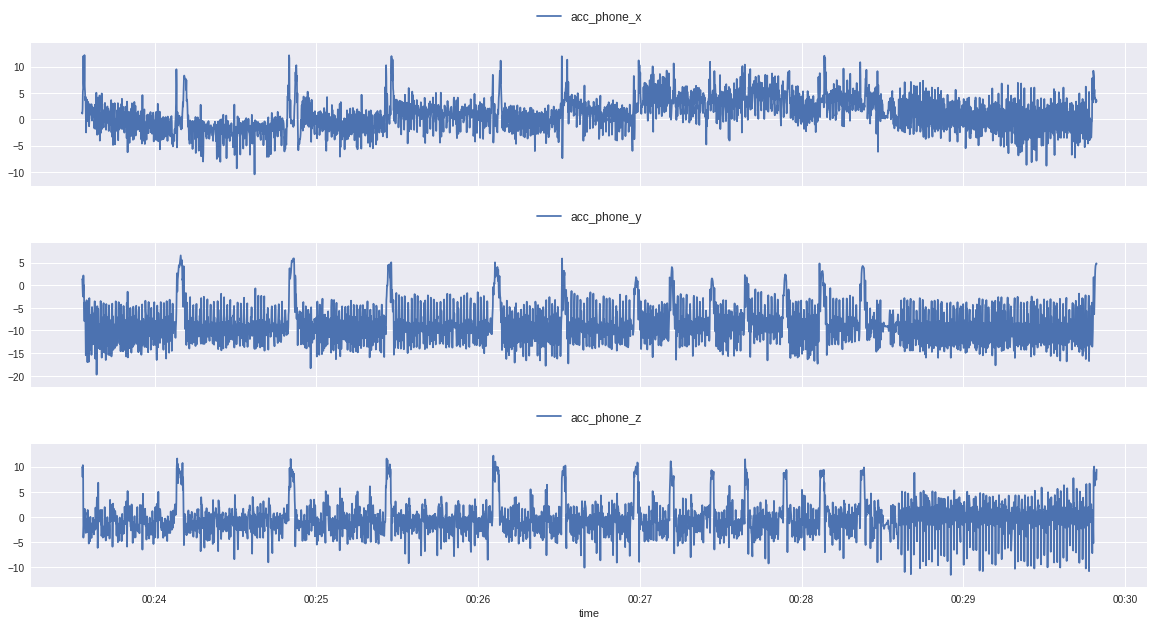

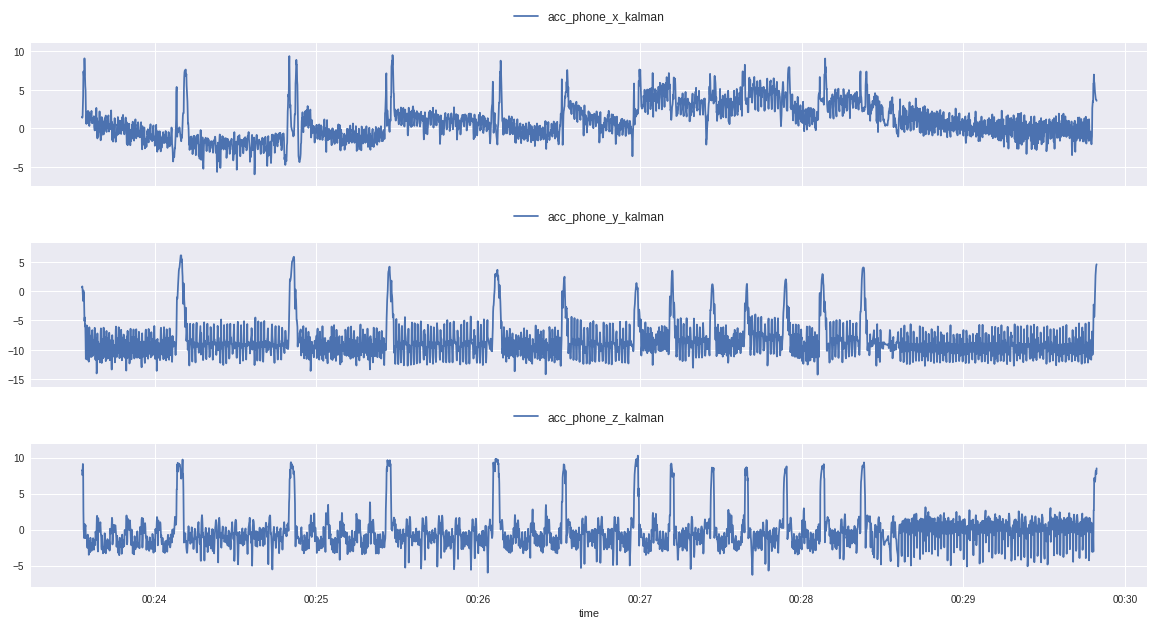

In [22]:
DataViz.plot_dataset(kalman_dataset, ['acc_phone_x','acc_phone_y','acc_phone_z'],
                     ['exact','exact','exact'], 
                     ['line','line','line'])
DataViz.plot_dataset(kalman_dataset, ['acc_phone_x_kalman','acc_phone_y_kalman','acc_phone_z_kalman'],
                     ['exact','exact','exact'], 
                     ['line','line','line'])

### Section 2.3 Apply PCA to get principal component values.

['acc_phone_x_kalman', 'acc_phone_y_kalman', 'acc_phone_z_kalman', 'gyr_phone_x_kalman', 'gyr_phone_y_kalman', 'gyr_phone_z_kalman', 'rotation_phone_x_kalman', 'rotation_phone_y_kalman', 'rotation_phone_z_kalman', 'rotation_phone_theta_kalman', 'rotation_phone_phi_kalman']


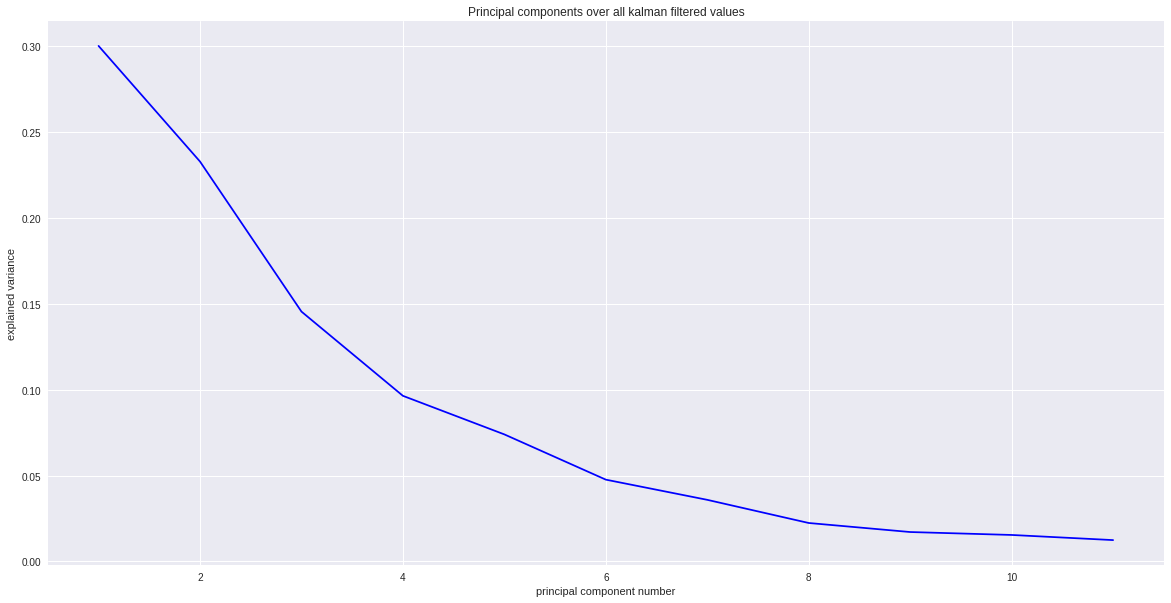

In [29]:
PCA = PrincipalComponentAnalysis()
# selected_predictor_cols = [c for c in dataset.columns if (not ('label' in c)) and (not (c == 'rotation_phone_theta'))]
# selected_predictor_cols = missing_values
selected_predictor_cols = [x for x in kalman_dataset.keys() if '_kalman' in x]
# selected_predictor_cols += ['rotation_phone_z','rotation_phone_theta','rotation_phone_phi']
print(selected_predictor_cols)
pc_values = PCA.determine_pc_explained_variance(kalman_dataset, selected_predictor_cols)
plt.plot(range(1, len(selected_predictor_cols)+1), pc_values, 'b-')
plt.xlabel('principal component number')
plt.ylabel('explained variance')
plt.title('Principal components over all kalman filtered values')
plt.savefig(os.path.join(figures_folder,'./kalman/pca_kalman.png'))
plt.show()
#Derived from the plot
n_pcs = 6

In [32]:

kalman_dataset = PCA.apply_pca(copy.deepcopy(kalman_dataset), selected_predictor_cols, n_pcs)
kalman_dataset.head()

,acc_phone_x,acc_phone_y,acc_phone_z,gyr_phone_x,gyr_phone_y,gyr_phone_z,rotation_phone_x,rotation_phone_y,rotation_phone_z,rotation_phone_theta,...,rotation_phone_y_kalman,rotation_phone_z_kalman,rotation_phone_theta_kalman,rotation_phone_phi_kalman,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6
2017-06-25 00:23:33.041,1.240270,1.302482,9.858076,-0.094845,0.019277,-0.024629,-0.019180,-0.106263,-0.743605,0.659841,...,-0.110791,-0.728983,0.653936,2.071418,0.258084,0.780681,0.401610,0.602719,0.314064,0.094137
2017-06-25 00:23:33.141,1.057461,1.162243,9.731683,-0.013016,-0.384871,0.094654,-0.023237,-0.107200,-0.742126,0.661197,...,-0.108458,-0.737547,0.658575,2.086012,0.259994,0.789588,0.412199,0.627136,0.333753,0.081283
2017-06-25 00:23:33.241,1.936194,-0.785147,7.920569,-0.522966,-2.068360,0.912229,-0.074518,-0.139692,-0.727066,0.667087,...,-0.129712,-0.730386,0.664258,2.091576,0.255409,0.806666,0.390900,0.600436,0.342518,0.118176
2017-06-25 00:23:33.341,5.189648,-2.318559,10.280083,0.410664,-3.037739,2.096176,-0.192034,-0.205669,-0.658469,0.695692,...,-0.181636,-0.681025,0.685342,2.093456,0.217231,0.823084,0.365848,0.678079,0.253405,0.186264
2017-06-25 00:23:33.441,5.908813,-2.527823,8.026489,4.366754,NaN,3.421865,-0.277558,-0.395984,-0.459495,0.733581,...,-0.328228,-0.528908,0.717714,2.094083,0.104839,0.849890,0.347328,0.856635,-0.126780,0.186010


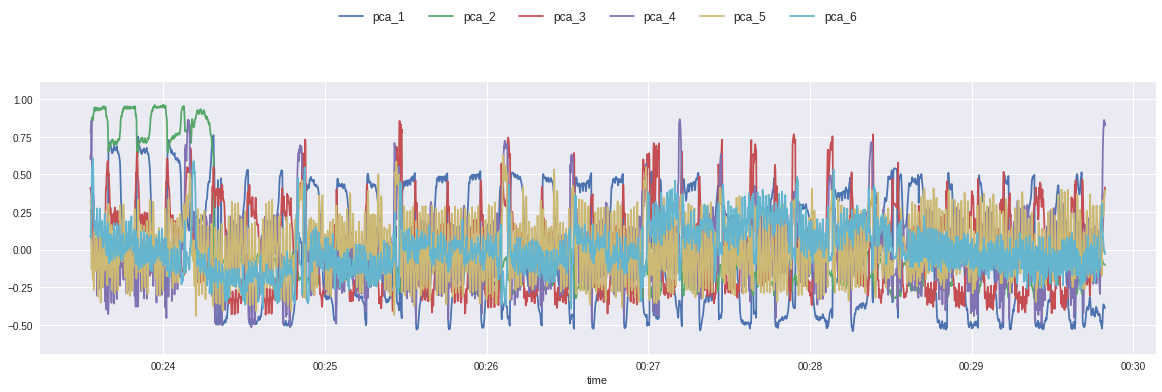

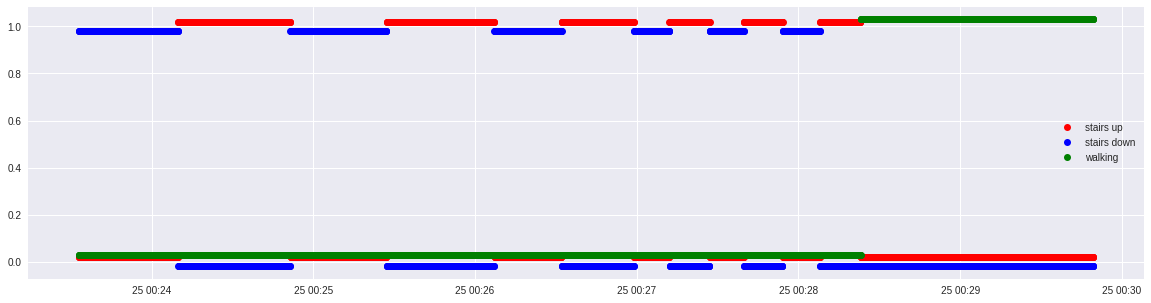

In [37]:
rcParams['figure.figsize'] = (20,5)
DataViz.plot_dataset(kalman_dataset, ['pca_'], ['like'], ['line'])
plt.plot(kalman_dataset['labelstairsup']+0.02,'ro')
plt.plot(kalman_dataset['labelstairsdown']-0.02,'bo')
plt.plot(kalman_dataset['labelwalking']+0.03,'go')
plt.legend(['stairs up','stairs down','walking'])
plt.savefig(os.path.join(figures_folder,'./kalman/kalman_labels.png'))
plt.show()

In [35]:
kalman_dataset.to_csv(result_dataset_path+'/'+str(millis)+'_dataset_rest.csv')

# Section 3 : Chapter4 -  Feature Engineering

In [41]:
### choose a dataset to filter:
DataViz = VisualizeDataset()
millis = 100
rcParams['figure.figsize'] = (20,10)
dataset = pd.read_csv(os.path.join(result_dataset_path,str(millis)+'_dataset_rest.csv'),index_col=0)
dataset.index = pd.to_datetime(dataset.index)
milliseconds_per_instance = (dataset.index[1] - dataset.index[0]).microseconds/1000
print("Using milliseconds per instance: %d"%milliseconds_per_instance)
window_sizes = [int(float(5000)/milliseconds_per_instance), int(float(0.5*60000)/milliseconds_per_instance), int(float(2.*60000)/milliseconds_per_instance)]
print('Window sizes: %s'%str(window_sizes))
features_before = len(dataset.columns)
NumAbs = NumericalAbstraction()
CatAbs = CategoricalAbstraction()
if not os.path.exists(figures_folder+'/feature_engineering'):
    os.mkdir(figures_folder+'/feature_engineering')
dataset.head()

Using milliseconds per instance: 100
Window sizes: [50, 300, 1200]


,acc_phone_x,acc_phone_y,acc_phone_z,gyr_phone_x,gyr_phone_y,gyr_phone_z,rotation_phone_x,rotation_phone_y,rotation_phone_z,rotation_phone_theta,...,rotation_phone_y_kalman,rotation_phone_z_kalman,rotation_phone_theta_kalman,rotation_phone_phi_kalman,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6
2017-06-25 00:23:33.041,1.240270,1.302482,9.858076,-0.094845,0.019277,-0.024629,-0.019180,-0.106263,-0.743605,0.659841,...,-0.110791,-0.728983,0.653936,2.071418,0.258084,0.780681,0.401610,0.602719,0.314064,0.094137
2017-06-25 00:23:33.141,1.057461,1.162243,9.731683,-0.013016,-0.384871,0.094654,-0.023237,-0.107200,-0.742126,0.661197,...,-0.108458,-0.737547,0.658575,2.086012,0.259994,0.789588,0.412199,0.627136,0.333753,0.081283
2017-06-25 00:23:33.241,1.936194,-0.785147,7.920569,-0.522966,-2.068360,0.912229,-0.074518,-0.139692,-0.727066,0.667087,...,-0.129712,-0.730386,0.664258,2.091576,0.255409,0.806666,0.390900,0.600436,0.342518,0.118176
2017-06-25 00:23:33.341,5.189648,-2.318559,10.280083,0.410664,-3.037739,2.096176,-0.192034,-0.205669,-0.658469,0.695692,...,-0.181636,-0.681025,0.685342,2.093456,0.217231,0.823084,0.365848,0.678079,0.253405,0.186264
2017-06-25 00:23:33.441,5.908813,-2.527823,8.026489,4.366754,NaN,3.421865,-0.277558,-0.395984,-0.459495,0.733581,...,-0.328228,-0.528908,0.717714,2.094083,0.104839,0.849890,0.347328,0.856635,-0.126780,0.186010


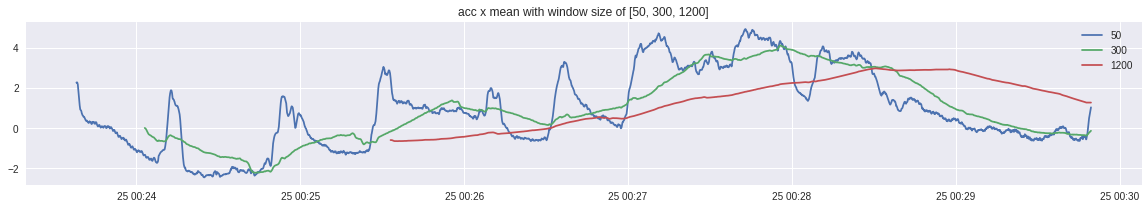

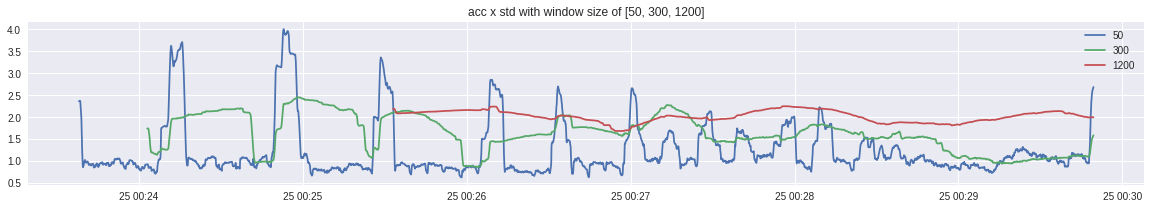

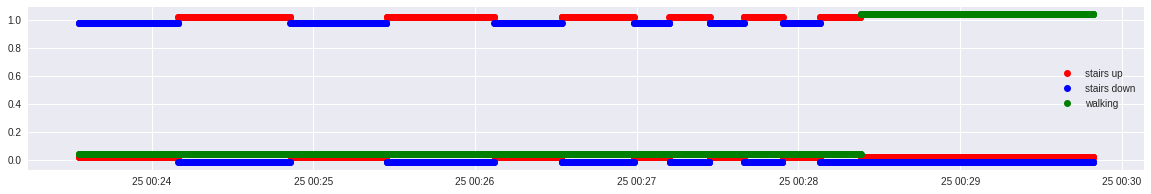

In [32]:
# dataset_copy = copy.deepcopy(dataset)
# for ws in window_sizes:
#     dataset_copy = NumAbs.abstract_numerical(dataset_copy, ['acc_phone_x_kalman'], ws, 'mean')
#     dataset_copy = NumAbs.abstract_numerical(dataset_copy, ['acc_phone_x_kalman'], ws, 'std')
rcParams['figure.figsize'] = (20,3)
plt.plot(dataset_copy['acc_phone_x_kalman_temp_mean_ws_%d'%(window_sizes[0])])
plt.plot(dataset_copy['acc_phone_x_kalman_temp_mean_ws_%d'%(window_sizes[1])])
plt.plot(dataset_copy['acc_phone_x_kalman_temp_mean_ws_%d'%(window_sizes[2])])
plt.title('acc x mean with window size of %s'%str(window_sizes))
plt.legend(window_sizes)
plt.savefig(os.path.join(figures_folder+'/feature_engineering','acc_x_time_domain_mean.png'))
plt.show()
plt.plot(dataset_copy['acc_phone_x_kalman_temp_std_ws_%d'%(window_sizes[0])])
plt.plot(dataset_copy['acc_phone_x_kalman_temp_std_ws_%d'%(window_sizes[1])])
plt.plot(dataset_copy['acc_phone_x_kalman_temp_std_ws_%d'%(window_sizes[2])])
plt.legend(window_sizes)
plt.title('acc x std with window size of %s'%str(window_sizes))
plt.savefig(os.path.join(figures_folder+'/feature_engineering','acc_x_time_domain_std.png'))
plt.show()
plt.plot(dataset_copy['labelstairsup']+0.02,'ro')
plt.plot(dataset_copy['labelstairsdown']-0.02,'bo')
plt.plot(dataset_copy['labelwalking']+0.04,'go')
plt.legend(['stairs up','stairs down','walking'])
plt.savefig(os.path.join(figures_folder,'labels.png'))
plt.show()


Number of features generated:6


In [43]:
window_index = 0
milliseconds_per_instance = 100

ws = window_sizes[window_index]
print('Creating features with window size %d'%ws)
selected_predictor_cols = [c for c in dataset.columns if not 'label' in c]
print('doing mean numerical abstraction')
dataset_ws = NumAbs.abstract_numerical(dataset, selected_predictor_cols, ws, 'mean')
print("doing std numerical abstraction")
dataset_ws = NumAbs.abstract_numerical(dataset_ws, selected_predictor_cols, ws, 'std')
print('Number of features generated:%d'%(len(dataset_ws.columns)-features_before))
# print('now doing categorical abstraction')
# dataset_ws = CatAbs.abstract_categorical(dataset_ws, ['label'], ['like'], 0.03, ws, 2)
dataset_ws.to_csv(os.path.join(result_dataset_path,
                               str(milliseconds_per_instance)+'_dataset_ws_'+str(ws)+'.csv'))


Creating features with window size 50
doing mean numerical abstraction
doing std numerical abstraction
Number of features generated:56


In [47]:
dataset_ws.sample(10)

,acc_phone_x,acc_phone_y,acc_phone_z,gyr_phone_x,gyr_phone_y,gyr_phone_z,rotation_phone_x,rotation_phone_y,rotation_phone_z,rotation_phone_theta,...,rotation_phone_y_kalman_temp_std_ws_50,rotation_phone_z_kalman_temp_std_ws_50,rotation_phone_theta_kalman_temp_std_ws_50,rotation_phone_phi_kalman_temp_std_ws_50,pca_1_temp_std_ws_50,pca_2_temp_std_ws_50,pca_3_temp_std_ws_50,pca_4_temp_std_ws_50,pca_5_temp_std_ws_50,pca_6_temp_std_ws_50
2017-06-25 00:27:39.441,2.401786,0.929627,9.444760,0.579742,-0.678123,0.470821,0.177275,-0.013271,0.935049,0.306352,...,0.403144,0.397551,0.151735,1.121270e-16,0.284455,0.092710,0.228492,0.166535,0.141678,0.115146
2017-06-25 00:28:34.141,-0.989083,-12.830360,-4.419230,1.088042,-2.885696,0.593983,-0.564694,0.544899,-0.482213,0.386257,...,0.379806,0.341512,0.057757,1.121270e-16,0.262320,0.048061,0.134291,0.103600,0.109837,0.077327
2017-06-25 00:27:38.941,10.362412,2.237367,8.529383,-0.467258,NaN,-1.871967,-0.087099,0.035584,-0.066195,0.052560,...,0.379959,0.364064,0.157683,1.121270e-16,0.284593,0.092367,0.196873,0.109483,0.139033,0.087803
2017-06-25 00:27:08.841,8.005772,-8.764275,-3.981121,-1.567594,0.053982,-0.694653,-0.703079,-0.326964,-0.030102,0.630209,...,0.369442,0.275919,0.216117,1.121270e-16,0.262531,0.090277,0.238872,0.120645,0.157639,0.087564
2017-06-25 00:29:35.441,5.117917,-12.863471,-1.516047,-1.846977,-0.886569,-0.420273,-0.666397,-0.125952,0.271700,0.682070,...,0.250712,0.226304,0.141875,1.121270e-16,0.192524,0.071459,0.124676,0.134766,0.171037,0.075421
2017-06-25 00:28:51.941,-2.023851,-3.665637,3.634203,0.613042,1.643562,0.286118,-0.463112,0.630406,-0.569387,0.249629,...,0.534040,0.460776,0.106547,1.121270e-16,0.374905,0.090829,0.129107,0.125292,0.187255,0.076847
2017-06-25 00:25:08.741,-7.110171,-10.997346,5.677657,-0.012936,0.413246,0.245126,-0.554098,0.502477,-0.424040,0.510394,...,0.436318,0.403193,0.102049,1.121270e-16,0.299112,0.058125,0.130813,0.135526,0.133257,0.061546
2017-06-25 00:29:30.541,1.078577,-8.919637,0.790765,0.958731,0.329931,0.592200,-0.575279,0.291821,-0.246454,0.723120,...,0.314236,0.306510,0.231710,1.121270e-16,0.190567,0.035766,0.268716,0.200739,0.146833,0.069285
2017-06-25 00:25:14.041,1.518263,-9.421109,-3.051195,1.533523,-0.715122,0.283989,-0.653407,-0.389703,0.388617,0.519277,...,0.255981,0.183563,0.069785,1.121270e-16,0.150497,0.027067,0.057295,0.113063,0.156936,0.057612
2017-06-25 00:29:48.141,3.191903,-6.791857,-2.133064,1.660890,-0.007959,-0.761837,-0.022626,-0.777595,0.365911,0.510122,...,0.130603,0.083503,0.073082,1.121270e-16,0.040605,0.012670,0.085272,0.148589,0.174159,0.097948


### Frequency Domain - Fourier Transformations.

In [54]:
ws = 50
dataset_after_ws = pd.read_csv(os.path.join(result_dataset_path,str(millis)+'_dataset_ws_'+str(ws)+'.csv'),index_col=0)
features_before_fft = dataset_after_ws.shape[1]
freq_step = 2000.
FreqAbs = FourierTransformation()
fs = float(freq_step/milliseconds_per_instance)
print("Current number of features:%d"%features_before_fft)
print("Frequency for FFT: %5.5f Time Domain Window:%d"%(fs,ws))
dataset_after_ws.head()

Current number of features:87
Frequency for FFT: 20.00000 Time Domain Window:50


,acc_phone_x,acc_phone_y,acc_phone_z,gyr_phone_x,gyr_phone_y,gyr_phone_z,rotation_phone_x,rotation_phone_y,rotation_phone_z,rotation_phone_theta,...,rotation_phone_y_kalman_temp_std_ws_50,rotation_phone_z_kalman_temp_std_ws_50,rotation_phone_theta_kalman_temp_std_ws_50,rotation_phone_phi_kalman_temp_std_ws_50,pca_1_temp_std_ws_50,pca_2_temp_std_ws_50,pca_3_temp_std_ws_50,pca_4_temp_std_ws_50,pca_5_temp_std_ws_50,pca_6_temp_std_ws_50
2017-06-25 00:23:33.041,1.240270,1.302482,9.858076,-0.094845,0.019277,-0.024629,-0.019180,-0.106263,-0.743605,0.659841,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-25 00:23:33.141,1.057461,1.162243,9.731683,-0.013016,-0.384871,0.094654,-0.023237,-0.107200,-0.742126,0.661197,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-25 00:23:33.241,1.936194,-0.785147,7.920569,-0.522966,-2.068360,0.912229,-0.074518,-0.139692,-0.727066,0.667087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-25 00:23:33.341,5.189648,-2.318559,10.280083,0.410664,-3.037739,2.096176,-0.192034,-0.205669,-0.658469,0.695692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-25 00:23:33.441,5.908813,-2.527823,8.026489,4.366754,NaN,3.421865,-0.277558,-0.395984,-0.459495,0.733581,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
periodic_predictor_cols =['acc_phone_x_kalman', 'acc_phone_y_kalman',
                          'acc_phone_z_kalman', 'gyr_phone_x_kalman', 
                          'gyr_phone_y_kalman', 'gyr_phone_z_kalman', 
                          'rotation_phone_x_kalman', 'rotation_phone_y_kalman',
                          'rotation_phone_z_kalman']
col = periodic_predictor_cols[0]
print('FFT in column %s'%col)
dataset_fft = FreqAbs.abstract_frequency(dataset_after_ws, [col], ws, fs)
for col in periodic_predictor_cols[1:]:
    print('FFT in column %s'%col)
    dataset_fft = FreqAbs.abstract_frequency(dataset_fft, [col], ws, fs)
print("Finished with fft transformations...")
window_overlap = 0.9
skip_points = int((1-window_overlap) * ws)
dataset_fft = dataset_fft.iloc[::skip_points,:]


FFT in column acc_phone_x_kalman
FFT in column acc_phone_y_kalman
FFT in column acc_phone_z_kalman
FFT in column gyr_phone_x_kalman
FFT in column gyr_phone_y_kalman
FFT in column gyr_phone_z_kalman
FFT in column rotation_phone_x_kalman
FFT in column rotation_phone_y_kalman
FFT in column rotation_phone_z_kalman
Finished with fft transformations...


In [ ]:
print('Number of features generated after time domain engineering:%d'%
      (len(dataset_fft.columns)-features_before_fft))
dataset_fft.to_csv(result_dataset_path+'/'+str(milliseconds_per_instance)+'_'+'final_dataset_fft_'+str(fs)+'_ws_'+str(ws)+'.csv')